# Our Team
- Rawda Ibrahim Mohamed  20221465540
- Aalaa Mahmoud Zahran  2106136
- Eyad Tamer Shehata 2103116
- Ziad Hassan  20225659140
- Abdelrahman Mohamed Ali  2103115
- Aly Gamal Salem  2103128
- Mohamed Gomaa Moustafa  2103129
- Omar Khaled Ahmed  2103113

# 1)Data collection plan specifying sources, formats, and preprocessing steps.

we got the data from kaggle the data consists of around 58 classes and each class has around 120 images. the data is about traffic signs . we aim to make a hidden trigger backdoor attack on this data.

In [45]:
from abc import ABC, abstractmethod
from PIL import Image 
import glob
import numpy as np
import os
from cv2 import resize
from PIL import Image
from matplotlib import pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [46]:
# dictionary containing configuration settings for data processing and model training.
config = {
    "data_path": "C:/Users/20100/Downloads/archive (4)/traffic_Data/DATA/",  # path where data is stored
    "img_size": (224, 224),  # desired size for images
    "img_extension": "png",  # file extension of images
    "device": "cuda" if torch.cuda.is_available() else "mps",  # device for computation
    "train_percentage": 90,  # percentage of data for training
    "batch_size": 256,  # number of samples processed at once during training
    "learning_rate": 0.01,  # learning rate for training
    "num_epochs": 5,  # number of complete passes through dataset during training
    "numpy_seed": 22,  # seed for random number generation in NumPy
    "torch_seed": 30,  # seed for random number generation in PyTorch
}

In [47]:
# setting seed for random number generation in NumPy for reproducibility
np.random.seed(config["numpy_seed"])
# setting seed for random number generation in PyTorch for reproducibility
torch.manual_seed(config["torch_seed"])

In [48]:
# defining an abstract base class for handling data
class DataHandler(ABC):
    # initializing data path, extension, and data storage
    def __init__(self, data_path, extension):
        self.data_path = data_path
        self.extension = extension
        self.data = None
        self.file_paths = []
        
    # abstract method for loading data, to be implemented by subclasses
    @abstractmethod
    def load_data(self):
        pass

# subclass of DataHandler for handling image data
class ImageHandler(DataHandler):
    # initializing with data path and extension, inheriting from DataHandler
    def __init__(self, data_path, extension):
        super().__init__(data_path, extension)
        
    # method for loading image data
    def load_data(self):
        # setting the offset for printing loading status
        print_offset = 10
        self.data = []  # initializing data storage
        
        # iterating through files in the data path
        for root, dirs, files in os.walk(self.data_path):
            for filename in files:
                # checking if the file has the specified extension
                if filename.endswith(self.extension):
                    file_path = root + "/" + filename  # getting the full file path
                    # printing loading status
                    print("\r Now Loading {}".format(file_path), end=' ' * print_offset)
                    self.file_paths.append(file_path)  # storing file path
                    img = np.array(Image.open(file_path))  # reading and converting image to array
                    self.data.append(img)  # storing image data
        print('\n Data Loaded')  # printing completion message
    
    # method for resizing images
    def resize_images(self, size):
        # resizing each image in the data
        self.data = [resize(img, size) for img in self.data]
        self.data = np.array(self.data)  # converting resized images to numpy array

In [49]:
# creating an instance of the ImageHandler class with specified data path and image extension from the configuration
handler = ImageHandler(config["data_path"], config["img_extension"])
# loading data using the load_data method of the ImageHandler instance
handler.load_data()

 Now Loading C:/Users/20100/Downloads/archive (4)/traffic_Data/DATA/9/009_1_0001.png               
 Data Loaded


In [50]:
handler.resize_images((224, 224))

In [51]:
handler.data.shape

(4170, 224, 224, 3)

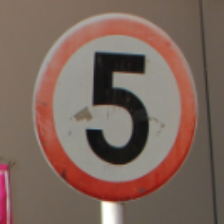

In [52]:
img = Image.fromarray(handler.data[0])
img

The images are located inside folders named after their corresponding class.

In [53]:
# empty list to store data labels
data_labels = []
# prefix for the path where the data is stored
path_prefix = "C:/Users/20100/Downloads/archive (4)/traffic_Data/DATA/"
# iterating over the file paths in the ImageHandler instance
for idx, fp in enumerate(handler.file_paths):
    # removing the path prefix and file extension from the file path
    tmp_string = fp.replace(path_prefix, "").replace(".png", "")
    # extracting the label from the modified file path
    label = tmp_string.split("/")[0]
    # converting the label to integer and appending it to the list of data labels
    data_labels.append(int(label))

# converting the list of data labels to a numpy array
data_labels = np.array(data_labels)


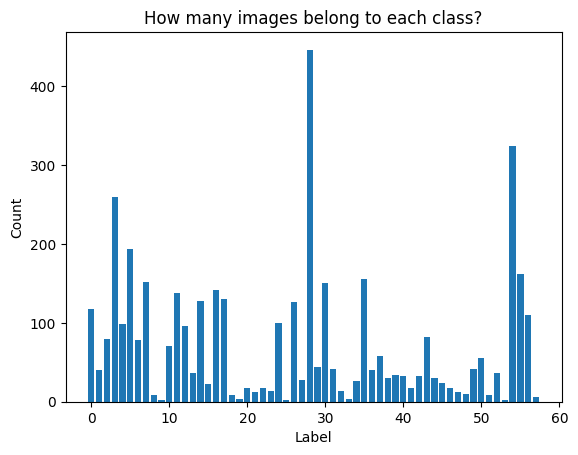

In [54]:
# initializing a Counter object to count the occurrences of each label
label_count = Counter()
# iterating over each label in the data labels
for label in data_labels:
    # incrementing the count for the current label
    label_count[label] += 1
# creating a bar plot using Matplotlib to visualize the distribution of labels
plt.bar(label_count.keys(), label_count.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('How many images belong to each class?')
plt.show()

Since the classes 54 and 28 are the most frequent ones, we only use them for our attack.

In [55]:
print(f"class 28 has {label_count[28]} samples and class 54 has {label_count[54]} samples")

class 28 has 446 samples and class 54 has 324 samples


The number of the samples for these classes do not match. In other words, the data is not balanced. Therefore, we need to balance the data. For this purpose, we randomly take 300 images from each class. Finally, we convert the labels 28 and 54 to 0 and 1, respectively.

In [56]:
# getting the indices of samples with label 28 (te_samples_idx) and label 54 (ff_samples_idx)
te_samples_idx = [idx for idx, label in enumerate(data_labels) if label == 28]
ff_samples_idx = [idx for idx, label in enumerate(data_labels) if label == 54]
# randomly selecting 300 samples from each label's indices without replacement
te_samples_idx = np.random.choice(te_samples_idx, 300, replace=False)
ff_samples_idx = np.random.choice(ff_samples_idx, 300, replace=False)
# extracting the image data and labels for the selected samples
te_x, ff_x = handler.data[te_samples_idx], handler.data[ff_samples_idx]
te_y, ff_y = data_labels[te_samples_idx], data_labels[ff_samples_idx]
# concatenating the data and labels for both labels
x = np.concatenate((te_x, ff_x), axis=0)
y = np.concatenate((te_y, ff_y), axis=0)
# defining a function to convert labels to binary (0 for label 28, 1 for label 54)
label_converter = lambda x: 0 if x == 28 else 1
# applying the label converter function to all labels and storing the result in y
y = np.vectorize(label_converter)(y)

In [57]:
x.shape

(600, 224, 224, 3)

In [58]:
y.shape

(600,)

In [59]:
np.unique(y)

array([0, 1])

In [60]:
x_tmp = x / 255.0
y_tmp = y.copy()

# Splitting data into training and testing. 

In [61]:
# Splitting the dataset into training and remaining data using train_test_split function
# x_tmp and y_tmp are the input features and labels respectively
# test_size is set to 1 - train_percentage / 100 to ensure the training percentage is good compared to the test
x_train, x_rem, y_train, y_rem = train_test_split(x_tmp, y_tmp, test_size=1 - config["train_percentage"] / 100, random_state=50)

# Splitting the remaining data into test and development sets using train_test_split function
# test_size is set to 0.5 to split the remaining data equally between test and development sets
x_test, x_dev, y_test, y_dev = train_test_split(x_rem, y_rem, test_size=0.5, random_state=50)


In [62]:
del x_tmp, y_tmp